In [1]:
# Bruno Ugolini
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1.1 Birth Rates

The data on US births, provided by the CDC is in `data/births.csv`.

Reproduce the following plot of births by gender over time given the data:

![](births_gender.png)

Note the `1e6` on the y axis for scale

Text(0, 0.5, 'total births per year')

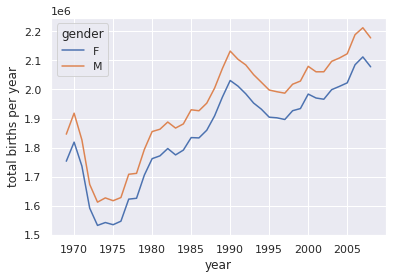

In [2]:
df = pd.read_csv('data/births.csv')
sns.set()
df[df.gender == 'F'].groupby(by='year').sum()['births'].plot(label='F')
df[df.gender == 'M'].groupby(by='year').sum()['births'].plot(label='M')
plt.legend(title='gender')
plt.ylabel('total births per year')

# 1.2 Births anomalies

This was analyzed by beloved statistician Andrew Gelman [here](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/), leading to this plot:

![](births_gp100.png)

Explain all three plots in Gelman's figure. 

**1.2:** What is the periodic component? What is the residual? Use your research skills to learn then explain it (in english).

Top chart:
==========

The black line represents the average number of births per day for a given calendar date presumably collected over many years (1969 to 1988). The data for Feb. 29th was multiplied by 4 to account for leap years.

The "Smoothed" line represents represents a high-order polynomial fit or rolling average to the data in order to remove the higher frequency variations.

The "Mean" represents the mean of the entire dataset ... however, it was normalized to 100 for simplicity. Chris's original chart showed the actual average per the 20-year period.

Middle chart:
=============

This is the attempt to model the periodic (repeated variation with time; oscillatory) of the black line about the smoothed line (from the first chart). The author used three componenets: "2 slowly varying components" (i.e. two long-wavelength cosine series for example) and "a periodic component with decay". This latter is equivalent to a spring-mass-damper system. Example: you hit a speed bump at higher speed than you should. Your car oscillates up and down but the amplitude of that motion decays with time while keeping its sinusodial nature.

Presumably, all of these components + the smoothed line would give you back the black line (see below). And so by this decomposition, an insight is gained into the underlying nature of the data. Let's call this accumulation of curves the "fit".

Bottom chart:
=============

This is the "fit" minus the black curve at the top: the error that cannot be explained by this well-behaved and generally well-fitting model. This chart is used to identify elements that don't fall into the logical modelling of all the other data. The (US) holidays stand out. Because doctors are home with families and don't have time to deliver babies.




# 1.3 Holiday Anomalies Plot

Reproduce *as best you can* the first of the 3 figures from Andrew Gelman's blog post (your plot may have small differences)

**1.3.1:** Reproduce the births line in a plot. Hint: Make the x axis a `pd.datetime` object

**1.3.2:** Reproduce the `smoothed` line. Hint: use a rolling window average

**1.3.3:** Reproduce the entire figure with the mean line as a horizontal. You can make the y axis total births instead of a % deviation from mean axis (they'll look the same anyway)

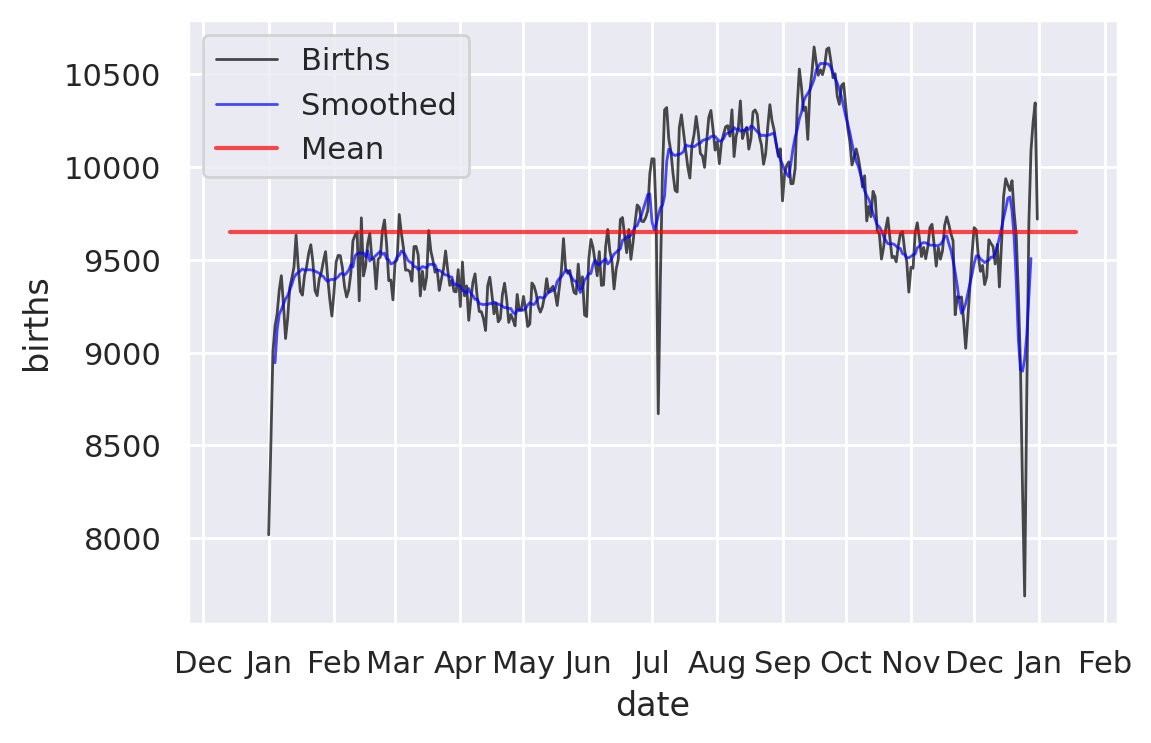

In [3]:
df = pd.read_csv('data/births_q2.csv')
# create a datetime variable
df['year']=2020
#      drop dates that don't make sense
df = df.drop(index=df.loc[(df.month == 2) & (df.day > 29)].index)
df = df.drop(index=df.loc[(df.month.isin([4,6, 9,11])) & (df.day > 30)].index)
#      fix Feb. 29th data
x = df['births'].loc[(df.month==2) & (df.day==29)].index
fix_feb_29 = df.xs(x[0])['births'] * 4
df.xs(x[0])['births'] = fix_feb_29
#  finally create the variable time
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
#  divide births by 20 years
df['births'] = df['births']/20

# clean dataset
df = df.drop(columns=['year','month','day']).set_index('date')

rolling = df.rolling(7, center=True)

# get a rolling average
fig, ax = plt.subplots(dpi=200, figsize=(6,4))
sns.lineplot(data=df,x=df.index,y='births',color='black',lw=1,alpha=0.7,label='Births')
sns.lineplot(data=rolling.mean(),x=rolling.mean().index,y='births',color='blue',lw=1,alpha=0.7,label='Smoothed')
mean_all = df.births.mean()
xmin, xmax = ax.get_xlim()
plt.plot([xmin,xmax],[mean_all,mean_all],color='red',alpha=0.7,label='Mean')

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.dates as mdates
months = mdates.MonthLocator()
month_fmt = mdates.DateFormatter('%b')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(month_fmt)
plt.legend()

# 2. Recipe Database

### 2.1 

Load the JSON recipe database we saw in lecture 4.

How many of the recipes are for breakfast food? Hint: The `description` would contain the work "breakfast"

In [4]:
import gzip
# read the entire file into a Python array
with gzip.open('data/recipe.json.gz', 'r') as f:
    # Extract each line
    data = (line.strip().decode() for line in f)
    # Reformat so each line is the element of a list
    data_json = f"[{','.join(data)}]"
# read the result as a JSON
recipes = pd.read_json(data_json)

In [5]:
#recipes.dropna(subset=['description'], inplace=True)
sum(recipes['description'].str.contains('breakfast').dropna())
# Answer: there are 3442 breakfast recipes

3442

### 2.2 A simple recipe recommender

Let's build a recipe recommender: given a list of basic ingredients, find a recipe that uses all those ingredients.

Here is the list of ingredients that can be asked for:

```
['salt', 'pepper', 'oregano', 'sage', 'parsley',
 'rosemary', 'tarragon', 'thyme', 'paprika', 'cumin']
```

**Hint:** Build a new column for each of the ingredients that indicates whether that ingredient is in the recipe.

**example:**
```
recommend_ingredients(["parsley", "paprika", "tarragon"], df)

result: 
# The rows where these 3 ingredients are in the recipe
[2069, 74964, 93768, 113926, 137686, 140530, 158475, 158486, 163175, 165243]
```

In [6]:
recipes['ingredients'].isin(['Biscuits'])
recipes['ingredients'].str.contains('flour', regex=False, case=False)

def recommend_ingredients(ing_lst, df):
    """
    Finds the index of recipes
    which contain all ingredients
    in ing_lst.
    """

    res = df.ingredients.apply(lambda sentence: all(word in sentence for word in ing_lst))
    return df[res].index

In [7]:
res = recommend_ingredients(["parsley", "paprika", "tarragon"], recipes)
res

Int64Index([2069, 74964, 93768, 113926, 137686, 140530, 158475, 158486, 163175,
            165243],
           dtype='int64')

# 3. Movies!

Recall the [Movies Dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset) from lecture 4. It's made up of several tables which we've played with in lecture 4.

The tables have common columns (`id` and `movie_id`) around which you can merge and join tables.

### 3.1 best director

Your task is to find **The best director** in terms of average ratings of his movies. This can be from the `ratings` or `ratings_small` table, or simply the vote average in the `metadata` table. The director can be found in the `cast` table.

You will have to use all of your skills to get this done, between using groupbys and merging multiple tables together

In [2]:
import pandas as pd
import numpy as np
import json
import re

#==========================================
#
#  Get the Director names from credits.csv
#
#==========================================
# Read in the credits data file to find the director names
credits = pd.read_csv('data/credits.csv')

In [3]:
def unpack_row(r):
    """
    This function is an 
    accumulation of regex and 
    string manipulations to
    get a json-compatible format
    for each row in the DataFrame.

    It caters mostly for the variations
    of names like "O'Conner" and 
    'Charles "Chuck" Shulz' both of 
    which cause errors when reading.
    """
    r = re.sub(r"(?<=[A-Za-zÀ-ÿ])'(?=[A-Za-zÀ-ÿ])", " ", r)  # fixes O'Conner and variants
    r = re.sub(r"(?<=[A-Za-z.]\s)'(?=[A-Za-z])", " ", r) # fixes first part of nickname Reggie "J.R" Jackson
    r = re.sub(r"(?<=[A-Za-z.])'(?=\s[A-Za-z])", " ", r) # fixes last part of nickname
    r = re.sub(r"(?<=:\s)\"'(?=[A-Za-z])", '"', r) # fixes "'Chema' Hernandez" first single quote
    r = r.replace('\'",', '",') # fixes "Randy 'Fife'" ending quotes
    r = r.replace(': "', ": '") # fixes "Janice O'Conner" start double quotes
    r = r.replace('" :', "' :") # fixes double quotes on O' names end
    r = r.replace('",', "',") # fixes double quotes on O' names end
    r = r.replace('"}', "'}") # fixes double quotes at end of set
    r = r.replace('"', ' ') # eliminates any remaining double quotes
    r = r.replace("'", '"') # convert all single to double quotes
    r = r.replace('None,','"None"')
    r = r.replace('None}','"None"}')
    r = json.loads(r,strict=False)
    for d in r:
        if d['job'] == 'Director':
            return d['name']
    return 'NaN'

# call the string cleaner
res = credits.crew.apply(unpack_row)

# build the dataframe
directors = pd.DataFrame(np.array(res), index = credits.id, columns=['directors'])
directors

,directors
id,
862,John Lasseter
8844,Joe Johnston
15602,Howard Deutch
31357,Forest Whitaker
11862,Charles Shyer
...,...
439050,Hamid Nematollah
111109,Lav Diaz
67758,Mark L. Lester


In [4]:
#==========================================
#
#  Get the Ratings from ratings.csv
#
#==========================================
ratings = pd.read_csv('data/ratings.csv')
ratings

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556
...,...,...,...,...
26024284,270896,58559,5.0,1257031564
26024285,270896,60069,5.0,1257032032
26024286,270896,63082,4.5,1257031764
26024287,270896,64957,4.5,1257033990


In [5]:
# select 1000 as the number of ratings
# we need for a movie in order to 
# consider its rating
N = 1000

# collect the movie id's where this
# is the case.
ratings_ovr_N = ratings.where(ratings.groupby(by='movieId').count()['userId'] >= N).dropna(axis=0)
ratings_ovr_N

,userId,movieId,rating,timestamp
1,1.0,147.0,4.5,1.425942e+09
2,1.0,858.0,5.0,1.425942e+09
3,1.0,1221.0,5.0,1.425942e+09
4,1.0,1246.0,5.0,1.425942e+09
5,1.0,1968.0,4.0,1.425942e+09
...,...,...,...,...
166528,1740.0,141.0,3.0,8.666372e+08
166635,1740.0,569.0,3.0,8.666491e+08
166643,1740.0,594.0,5.0,8.666478e+08
168250,1757.0,3152.0,4.0,9.459911e+08


In [6]:

# Gather all the raw scores for those 
# movies in ratings dataframe
ratings_lrg = ratings.loc[ratings.movieId.isin(pd.Series(ratings_ovr_N.movieId,dtype='int64'))]

# Group by movie id and get the
# mean rating.
ratings_lrg = ratings_lrg.groupby(by='movieId').mean().drop(['userId','timestamp'],axis=1)
ratings_lrg

,rating
movieId,
1,3.888157
2,3.236953
3,3.175550
4,2.875713
5,3.079565
...,...
167766,4.000000
168252,3.915125
168612,3.328947


In [9]:
#==========================================
#
#  Get the Ratings from metadata.csv
#
#==========================================
metaratings = pd.read_csv('data/movies_metadata.csv')

# collect the movies for which we 
# have over 1000 ratings
meta = metaratings[['id','title','vote_average']].where(metaratings.vote_count >= N).dropna(axis=0).copy()
meta.id = meta.id.astype(int)
meta

,id,title,vote_average
0,862,Toy Story,7.7
1,8844,Jumanji,6.9
5,949,Heat,7.7
9,710,GoldenEye,6.6
15,524,Casino,7.8
...,...,...,...
43644,339403,Baby Driver,7.2
44009,324852,Despicable Me 3,6.2
44274,281338,War for the Planet of the Apes,6.7
44678,374720,Dunkirk,7.5


In [8]:
#==========================================
#
#  Merging Directors with Ratings
#
#==========================================

movies = pd.merge(directors,ratings_lrg,left_index=True,right_index=True,how='left')
movies.index.rename('movie_id',inplace=True)
movies.index = movies.index.astype(int)
movies

,directors,rating
movie_id,,
2,Aki Kaurismäki,3.236953
3,Aki Kaurismäki,3.175550
5,Allison Anders,3.079565
6,Stephen Hopkins,3.841764
11,George Lucas,3.660591
...,...,...
465044,Molly Smith,NaN
467731,Sidney Lumet,NaN
468343,Jack Witikka,NaN


In [10]:
#==========================================
#
#  Merging with meta data scores
#
#==========================================

mov_all = pd.merge(movies,meta,left_on='movie_id',right_on='id',how='left')
mov_all

,directors,rating,id,title,vote_average
0,Aki Kaurismäki,3.236953,NaN,NaN,NaN
1,Aki Kaurismäki,3.175550,NaN,NaN,NaN
2,Allison Anders,3.079565,NaN,NaN,NaN
3,Stephen Hopkins,3.841764,NaN,NaN,NaN
4,George Lucas,3.660591,11.0,Star Wars,8.1
...,...,...,...,...,...
45471,Molly Smith,NaN,NaN,NaN,NaN
45472,Sidney Lumet,NaN,NaN,NaN,NaN
45473,Jack Witikka,NaN,NaN,NaN,NaN
45474,Hannaleena Hauru,NaN,NaN,NaN,NaN


In [11]:
#==========================================
#
#  Top 10 directors using ratings.csv data
#
#==========================================
mov_all.groupby(by='directors').mean().sort_values(by='rating',ascending=False).head(10)

,rating,id,vote_average
directors,,,
Lee Tamahori,4.266531,36669.0,5.8
Ken Kwapis,4.230716,NaN,NaN
George Pollock,4.213030,NaN,NaN
Jean-Charles Tacchella,4.202589,NaN,NaN
Sylvie Verheyde,4.182071,NaN,NaN
Dean Parisot,4.174583,146216.0,6.4
Jonathan Mostow,4.169975,10127.5,5.9
George Gallo,4.167063,NaN,NaN
Todd Robinson,4.157716,NaN,NaN


In [12]:
#==========================================
#
#  Top 10 directors using meta data
#
#==========================================
mov_all.groupby(by='directors').mean().sort_values(by='vote_average',ascending=False).head(10)

,rating,id,vote_average
directors,,,
Makoto Shinkai,NaN,372058.000000,8.500000
Roberto Benigni,2.846865,637.000000,8.300000
Irvin Kershner,NaN,1891.000000,8.200000
Eric Toledano,NaN,77338.000000,8.200000
Fernando Meirelles,2.374772,598.000000,8.200000
Tony Kaye,3.794658,73.000000,8.200000
Sidney Lumet,3.073592,389.000000,8.200000
Hayao Miyazaki,NaN,3396.000000,8.175000
Sergio Leone,NaN,358.333333,8.166667


In [13]:
#==========================================
#
#  Top 10 directors using both scores averaged
#
#==========================================

mov_all = mov_all.dropna(axis=0)
mov_all['both_ratings'] = (mov_all.rating * 2 + mov_all.vote_average) / 2
mov_all.groupby(by='directors').mean().sort_values(by='both_ratings',ascending=False).head(10)

,rating,id,vote_average,both_ratings
directors,,,,
Brian De Palma,4.089309,111.0,8.0,8.089309
Frank Darabont,3.870980,497.0,8.2,7.970980
Tony Kaye,3.794658,73.0,8.2,7.894658
Kevin Costner,3.985714,581.0,7.6,7.785714
Jean-Pierre Jeunet,3.842241,194.0,7.8,7.742241
Paul Greengrass,3.978199,2502.0,7.2,7.578199
Rob Reiner,3.658548,235.0,7.8,7.558548
Christopher Nolan,3.566624,213.5,7.9,7.516624
John McTiernan,3.763978,562.0,7.5,7.513978


In [14]:
#==========================================
#
#  Brian De Palma is the best director
#  considering the results from both datasets
#  when looking at only movies with 1,000 or
#  more ratings.
#
#==========================================